# Deep Computer Vision Using Convolutional Neural Networks

In [53]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from functools import partial
from sklearn.datasets import load_sample_images

In [3]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Convolutional Layers
### Implementing Convolutional Layers With Keras

Let's load two sample images, rescale their pixel values to 0-1, and center crop them to small 70×120 images:

In [5]:
images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [6]:
images.shape

TensorShape([2, 70, 120, 3])

In [7]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [8]:
fmaps.shape

TensorShape([2, 64, 114, 32])

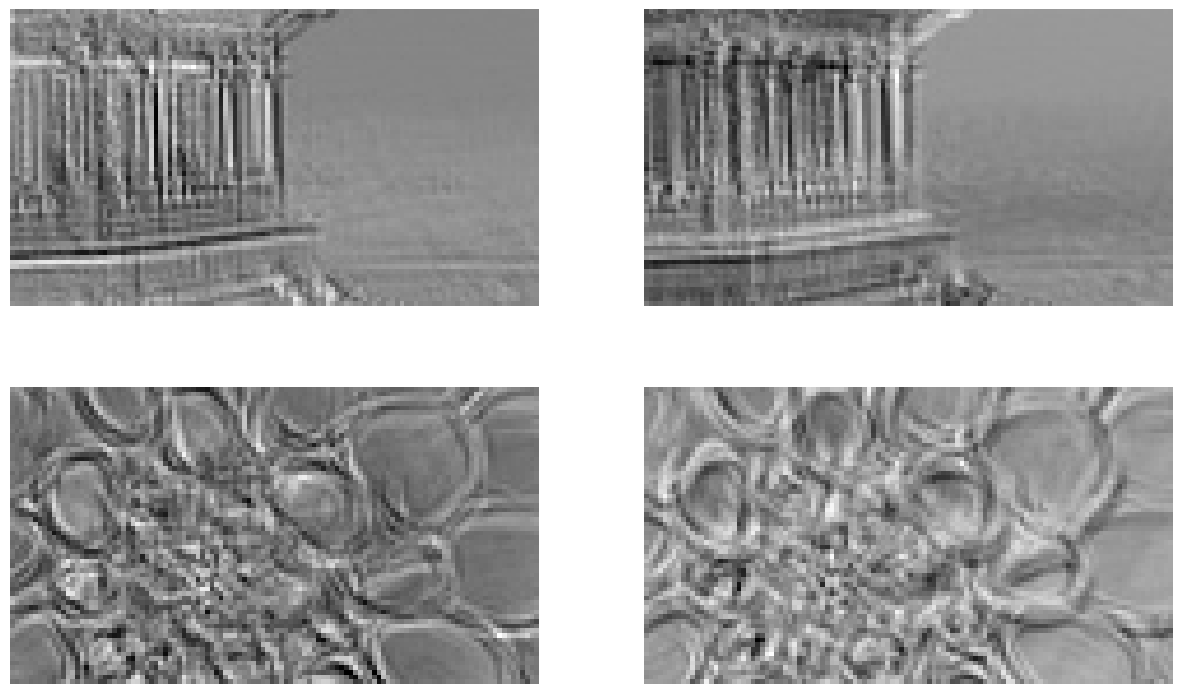

In [10]:
plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")
plt.show()

As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

Now let's use zero-padding:

In [11]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [12]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [13]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [15]:
def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

Let's now look at the weights:

In [16]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [17]:
biases.shape

(32,)

In [18]:
tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

Let's manually create two filters full of zeros, except for a vertical line of 1s in the first filter, and a horizontal one in the second filter (just like in Figure 14–5). The two output feature maps highlight vertical lines and horizontal lines, respectively. In practice you will probably never need to create filters manually, since the convolutional layers will learn them automatically.

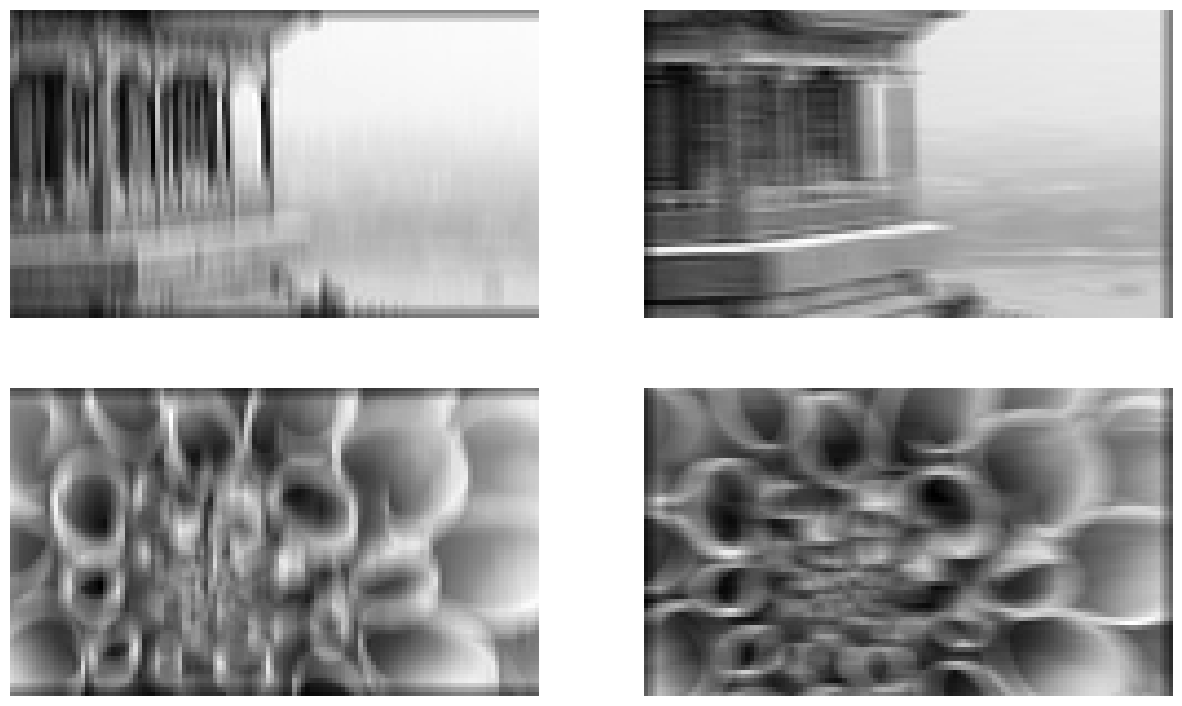

In [19]:
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Notice the dark lines at the top and bottom of the two images on the left, and on the left and right of the two images on the right? Can you guess what these are? Why were they not present in the previous figure?

You guessed it! These are artifacts due to the fact that we used zero padding in this case, while we did not use zero padding to create the feature maps in the previous figure. Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and bottom of the images. Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and right of the images.

## Pooling Layers
### Implementing Pooling Layers With Keras

**Max pooling**

In [20]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [21]:
output = max_pool(images)

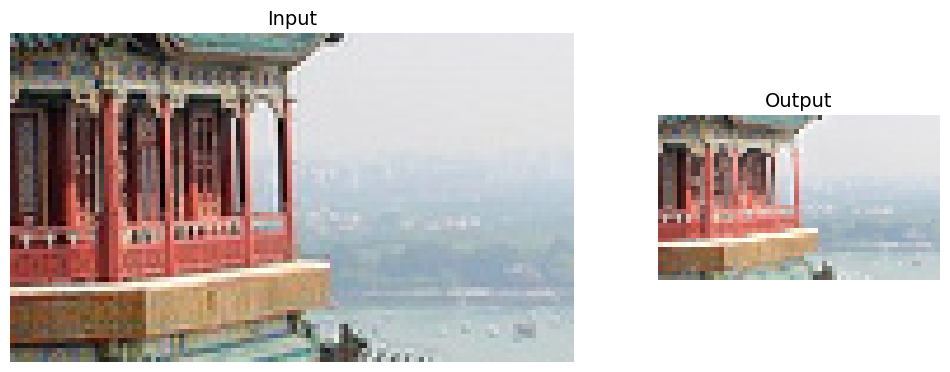

In [23]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

**Depth-wise pooling**

In [24]:
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [25]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [26]:
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

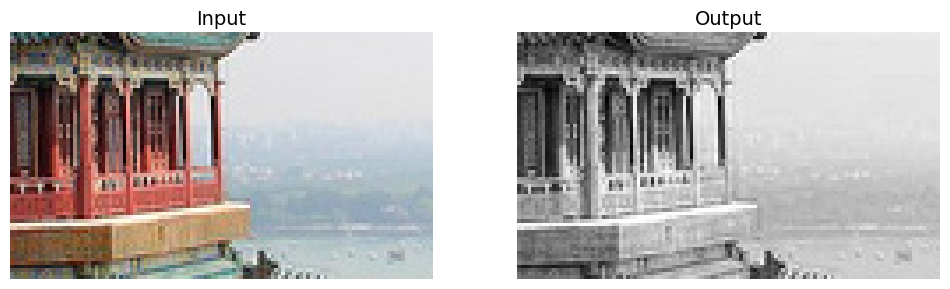

In [27]:
depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

**Global Average Pooling**

In [28]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

The following layer is equivalent:

In [29]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [30]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.2601113 , 0.10849128]], dtype=float32)>

## CNN Architectures

**Tackling Fashion MNIST With a CNN**

In [31]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [36]:
tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[28, 28, 1]),
    DefaultConv2D(filters=64, kernel_size=7),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

In [38]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 89s 52ms/step - accuracy: 0.7349 - loss: 0.7425 - val_accuracy: 0.8720 - val_loss: 0.3688
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 79s 46ms/step - accuracy: 0.8483 - loss: 0.4417 - val_accuracy: 0.8848 - val_loss: 0.3369
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 84s 49ms/step - accuracy: 0.8757 - loss: 0.3605 - val_accuracy: 0.8922 - val_loss: 0.2936
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 88s 51ms/step - accuracy: 0.8929 - loss: 0.3212 - val_accuracy: 0.8986 - val_loss: 0.2819
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.9021 - loss: 0.2938 - val_accuracy: 0.9020 - val_loss: 0.2683
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 84s 49ms/step - accuracy: 0.9071 - loss: 0.2772 - val_accuracy: 0.9036 - val_loss: 0.2707
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 84s 49ms/step - accuracy: 0.9122 - loss: 0.2549 - val_accuracy: 0.9016 - val_loss: 0.2739
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 84s 49ms/step - accuracy: 0.9180 -

## LeNet-5

The famous LeNet-5 architecture had the following layers:

Layer  | Type            | Maps | Size     | Kernel size | Stride | Activation
-------|-----------------|------|----------|-------------|--------|-----------
 Out   | Fully connected | –    | 10       | –           | –      | RBF
 F6    | Fully connected | –    | 84       | –           | –      | tanh
 C5    | Convolution     | 120  | 1 × 1    | 5 × 5       | 1      | tanh
 S4    | Avg pooling     | 16   | 5 × 5    | 2 × 2       | 2      | tanh
 C3    | Convolution     | 16   | 10 × 10  | 5 × 5       | 1      | tanh
 S2    | Avg pooling     | 6    | 14 × 14  | 2 × 2       | 2      | tanh
 C1    | Convolution     | 6    | 28 × 28  | 5 × 5       | 1      | tanh
 In    | Input           | 1    | 32 × 32  | –           | –      | –

There were a few tweaks here and there, which don't really matter much anymore, but in case you are interested, here they are:

* MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.
* The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.
* Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). See table 1 (page 8) in the [original paper](https://homl.info/lenet5) for details.
* The output layer is a bit special: instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and converging faster.

## Implementing a ResNet-34 CNN Using Keras

In [39]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[224, 224, 3]),
    DefaultConv2D(64, kernel_size=7, strides=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

## Using Pretrained Models from Keras

In [44]:
model = tf.keras.applications.ResNet50(weights="imagenet")

**Warning**: The expression `load_sample_images()["images"]` returns a Python list of images. However, in the latest versions, Keras does not accept Python lists anymore, so we must convert this list to a tensor. We can do this using `tf.constant()`, but here I have used `K.constant()` instead: it simply calls `tf.constant()` if you are using TensorFlow as the backend (as is the case here), but if you ever decide to use JAX or PyTorch as the backend instead, `K.constant()` will call the appropriate function from the chosen backend.

In [45]:
K = tf.keras.backend
images = K.constant(load_sample_images()["images"])
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

In [46]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [47]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


(2, 1000)

In [49]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.71%
  n02825657 - bell_cote    18.55%
Image #1
  n04522168 - vase         32.67%
  n11939491 - daisy        17.82%
  n03530642 - honeycomb    12.04%


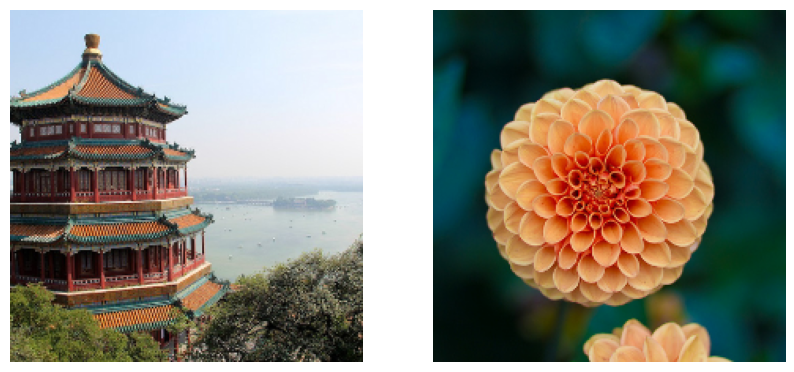

In [50]:
plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

## Pretrained Models for Transfer Learning

In [55]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [56]:
dataset_size

3670

In [57]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [58]:
n_classes

5

In [59]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

2025-07-29 16:54:43.315112: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


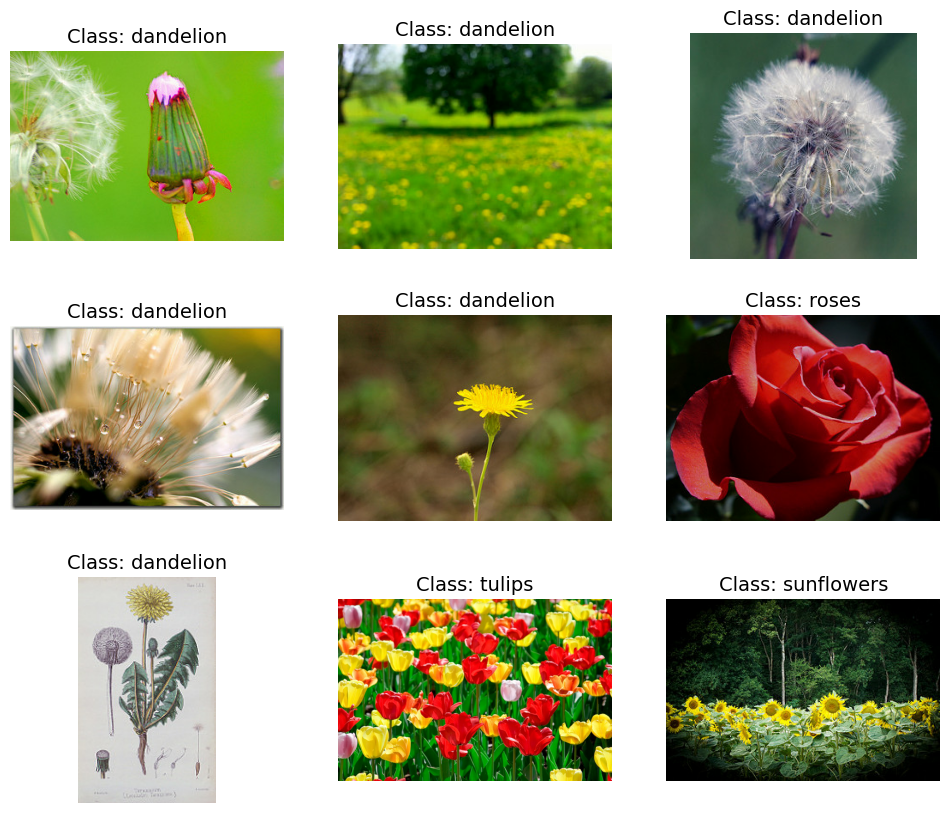

In [60]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

All three datasets contain individual images. We need to batch them, but for this we first need to ensure they all have the same size, or else batching will not work. We can use a `Resizing` layer for this. We must also call the `tf.keras.applications.xception.preprocess_input()` function to preprocess the images appropriately for the Xception model. We will also add shuffling and prefetching to the training dataset.

In [61]:
tf.keras.backend.clear_session()

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

Let's take a look again at the first 9 images from the validation set: they're all 224x224 now, with values ranging from -1 to 1:

2025-07-29 16:54:57.763733: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


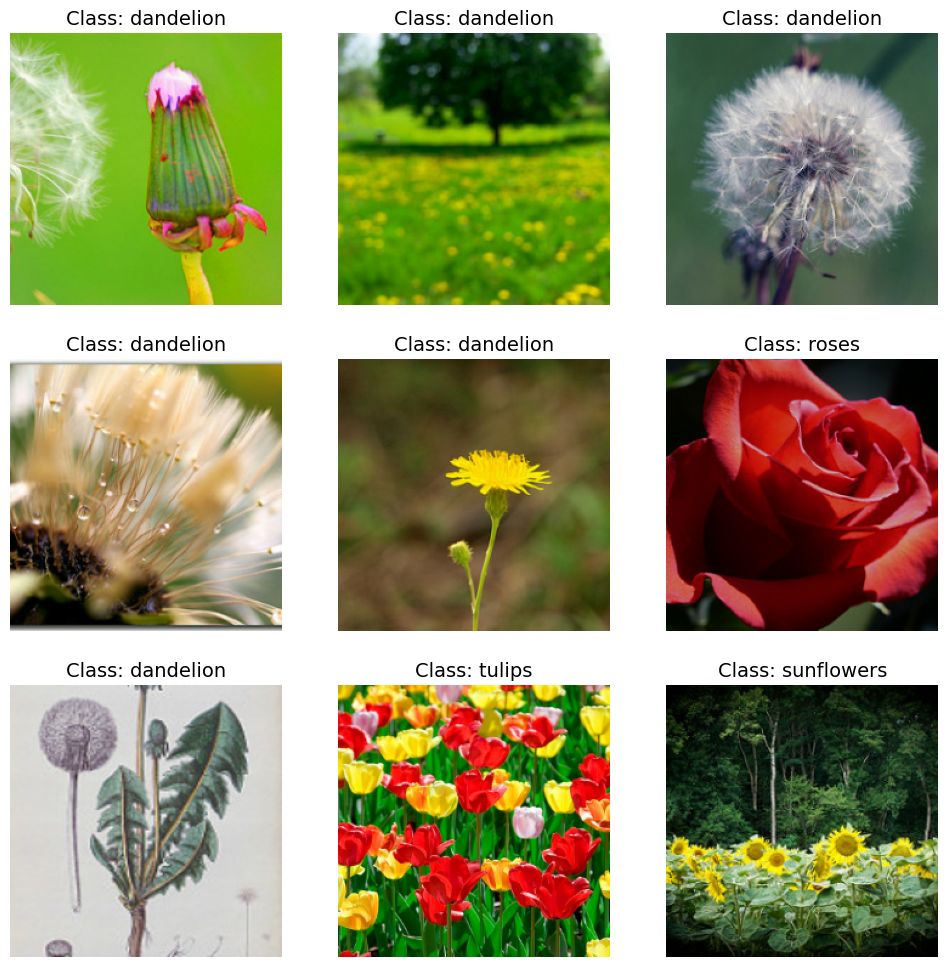

In [62]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [63]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

Try running the following cell multiple times to see different random data augmentations:

2025-07-29 16:55:07.774248: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


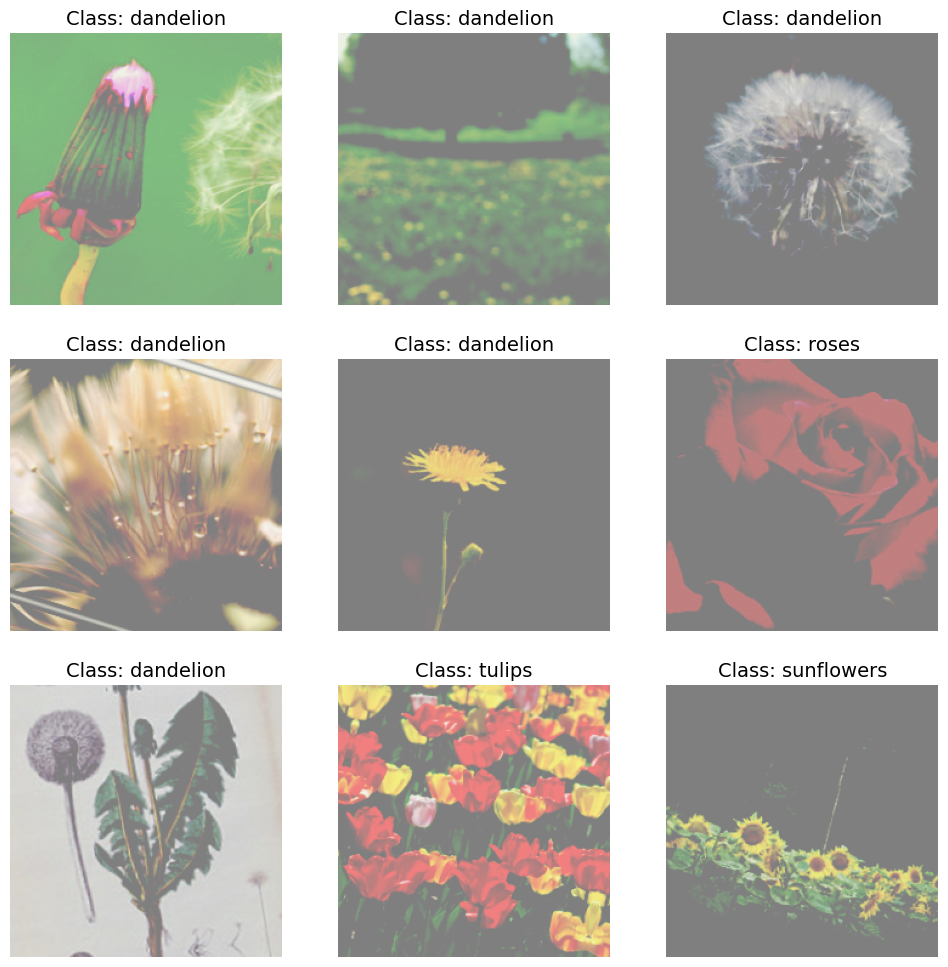

In [64]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

Now let's load the pretrained model, without its top layers, and replace them with our own, for the flower classification task:

In [66]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [67]:
for layer in base_model.layers:
    layer.trainable = False

Let's train the model for a few epochs, while keeping the base model weights fixed:

In [68]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 75s 861ms/step - accuracy: 0.7004 - loss: 1.0330 - val_accuracy: 0.8566 - val_loss: 0.7463
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 72s 842ms/step - accuracy: 0.8983 - loss: 0.3883 - val_accuracy: 0.8421 - val_loss: 0.7947
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 70s 814ms/step - accuracy: 0.9341 - loss: 0.1922 - val_accuracy: 0.7858 - val_loss: 1.1101


In [69]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_3          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_6  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_14                 68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_21                
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

Now that the weights of our new top layers are not too bad, we can make the top part of the base model trainable again, and continue training, but with a lower learning rate:

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.8662 - loss: 0.4608 - val_accuracy: 0.8766 - val_loss: 0.5328
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9792 - loss: 0.0651 - val_accuracy: 0.8947 - val_loss: 0.3738
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.9934 - loss: 0.0243 - val_accuracy: 0.9020 - val_loss: 0.3744
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9937 - loss: 0.0162 - val_accuracy: 0.9056 - val_loss: 0.3518
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9966 - loss: 0.0090 - val_accuracy: 0.9038 - val_loss: 0.3504
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.9971 - loss: 0.0072 - val_accuracy: 0.9002 - val_loss: 0.3404
Epoch 7/10
75/86 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9981 - loss: 0.0041